# Overview
- nb067ベース(cv:0.94102, sub:0.945)
- wavenet(roll)
- nb062(rfc(shallow))のproba使う
- ROLL_FEATS = True
- MOD_BATCH7 = True
- n_fold: 5
- n_feats: 23

# Const

In [1]:
NB = '077'
isSmallSet = False
if isSmallSet:
    LENGTH = 7000
else:
    LENGTH = 500_000

ROLL_FEATS = True
MOD_BATCH7 = True
PATH_PROBAS = './../data/output_ignore/probas_nb062_RandomForestClassifier_cv_0.9391.npz'

PATH_TRAIN = './../data/input/train_clean.csv'
PATH_TEST = './../data/input/test_clean.csv'
PATH_SMPLE_SUB = './../data/input/sample_submission.csv'
DIR_OUTPUT = './../data/output/'
DIR_OUTPUT_IGNORE = './../data/output_ignore/'
cp = ['#f8b195', '#f67280', '#c06c84', '#6c5b7b', '#355c7d']
sr = 10*10**3  # 10 kHz

# Import everything I need :)

In [2]:
import warnings
warnings.filterwarnings('ignore')
import time
import gc
import random
import os
import itertools
import multiprocessing
import numpy as np
from scipy import signal
# from pykalman import KalmanFilter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastprogress import progress_bar
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, GroupKFold
from sklearn.metrics import f1_score, mean_absolute_error, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
# from sklearn.svm import SVR
from sklearn.linear_model import Lasso
# from dtreeviz.trees import dtreeviz
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import losses, models, optimizers
# import tensorflow_addons as tfa

# My function

In [3]:
def f1_macro(true, pred):
    return f1_score(true, pred, average='macro')

def get_df_batch(df, batch):
    idxs = df['batch'] == batch
    assert any(idxs), 'そのようなbatchはありません'
    return df[idxs]
    
def get_signal_mv_mean(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).mean().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

def get_signal_mv_std(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).std().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

def get_signal_mv_min(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).min().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

def get_signal_mv_max(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).max().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv



def group_feat_train(_train):
    train = _train.copy()
    # group init
    train['group'] = int(0)

    # group 1
    idxs = (train['batch'] == 3) | (train['batch'] == 7)
    train['group'][idxs] = int(1)

    # group 2
    idxs = (train['batch'] == 5) | (train['batch'] == 8)
    train['group'][idxs] = int(2)

    # group 3
    idxs = (train['batch'] == 2) | (train['batch'] == 6)
    train['group'][idxs] = int(3)

    # group 4
    idxs = (train['batch'] == 4) | (train['batch'] == 9)
    train['group'][idxs] = int(4)
    
    return train[['group']]

def group_feat_test(_test):
    test = _test.copy()
    
    # group init
    test['group'] = int(0)
    x_idx = np.arange(len(test))

    # group 1
    idxs = (100000<=x_idx) & (x_idx<200000)
    test['group'][idxs] = int(1)
    idxs = (900000<=x_idx) & (x_idx<=1000000)
    test['group'][idxs] = int(1)

    # group 2
    idxs = (200000<=x_idx) & (x_idx<300000)
    test['group'][idxs] = int(2)
    idxs = (600000<=x_idx) & (x_idx<700000)
    test['group'][idxs] = int(2)

    # group 3
    idxs = (400000<=x_idx) & (x_idx<500000)
    test['group'][idxs] = int(3)

    # group 4
    idxs = (500000<=x_idx) & (x_idx<600000)
    test['group'][idxs] = int(4)
    idxs = (700000<=x_idx) & (x_idx<800000)
    test['group'][idxs] = int(4)
    
    return test[['group']]


class permutation_importance():
    def __init__(self, model, metric):
        self.is_computed = False
        self.n_feat = 0
        self.base_score = 0
        self.model = model
        self.metric = metric
        self.df_result = []
    
    def compute(self, X_valid, y_valid):
        self.n_feat = len(X_valid.columns)
        if self.metric == 'auc':
            y_valid_score = self.model.predict_proba(X_valid)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
            self.base_score = auc(fpr, tpr)
        else:
            pred = np.round(self.model.predict(X_valid)).astype('int8')
            self.base_score = self.metric(y_valid, pred)
        self.df_result = pd.DataFrame({'feat': X_valid.columns, 
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
        
        # predict
        for i, col in enumerate(X_valid.columns):
            df_perm = X_valid.copy()
            np.random.seed(1)
            df_perm[col] = np.random.permutation(df_perm[col])
            y_valid_pred = self.model.predict(df_perm)
            if self.metric == 'auc':
                y_valid_score = self.model.predict_proba(df_perm)[:, 1]
                fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
                score = auc(fpr, tpr)
            else:
                score = self.metric(y_valid, np.round(y_valid_pred).astype('int8'))
            self.df_result['score'][self.df_result['feat']==col] = score
            self.df_result['score_diff'][self.df_result['feat']==col] = self.base_score - score
        self.is_computed = True
    
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] < 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
        
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] > 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    
    def show_permutation_importance(self, score_type='loss'):
        '''score_type = 'loss' or 'accuracy'  '''
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        if score_type=='loss':
            ascending = True
        elif score_type=='accuracy':
            ascending = False
        else:
            ascending = ''
        
        plt.figure(figsize=(15, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=ascending))
        plt.title('base_score - permutation_score')

def plot_corr(df, abs_=False, threshold=0.95):
    if abs_==True:
        corr = df.corr().abs()>threshold
        vmin = 0
    else:
        corr = df.corr()
        vmin = -1

    # Plot
    fig, ax = plt.subplots(figsize=(12, 10), dpi=100)
    fig.patch.set_facecolor('white')
    sns.heatmap(corr,
                xticklabels=df.corr().columns,
                yticklabels=df.corr().columns,
                vmin=vmin,
                vmax=1,
                center=0, 
                annot=False)

    # Decorations
    ax.set_title('Correlation', fontsize=22)

def get_low_corr_column(df, threshold):

    df_corr = df.corr()
    df_corr = abs(df_corr)
    columns = df_corr.columns

    # 対角線の値を0にする
    for i in range(0, len(columns)):
        df_corr.iloc[i, i] = 0

    while True:
        columns = df_corr.columns
        max_corr = 0.0
        query_column = None
        target_column = None

        df_max_column_value = df_corr.max()
        max_corr = df_max_column_value.max()
        query_column = df_max_column_value.idxmax()
        target_column = df_corr[query_column].idxmax()

        if max_corr < threshold:
            # しきい値を超えるものがなかったため終了
            break
        else:
            # しきい値を超えるものがあった場合
            delete_column = None
            saved_column = None

            # その他との相関の絶対値が大きい方を除去
            if sum(df_corr[query_column]) <= sum(df_corr[target_column]):
                delete_column = target_column
                saved_column = query_column
            else:
                delete_column = query_column
                saved_column = target_column

            # 除去すべき特徴を相関行列から消す（行、列）
            df_corr.drop([delete_column], axis=0, inplace=True)
            df_corr.drop([delete_column], axis=1, inplace=True)

    return df_corr.columns  # 相関が高い特徴量を除いた名前リスト

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        if col!='open_channels':
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def create_signal_mod(train):
    left = 3641000
    right = 3829000
    thresh_dict = {
        3: [0.1, 2.0],
        2: [-1.1, 0.7],
        1: [-2.3, -0.6],
        0: [-3.8, -2],
    }
    
    train['signal'] = train['signal'].values
    for ch in train[train['batch']==7]['open_channels'].unique():
        idxs_noisy = (train['open_channels']==ch) & (left<train.index) & (train.index<right)
        idxs_not_noisy = (train['open_channels']==ch) & ~idxs_noisy
        mean = train[idxs_not_noisy]['signal'].mean()

        idxs_outlier = idxs_noisy & (thresh_dict[ch][1]<train['signal'].values)
        train['signal'][idxs_outlier]  = mean
        idxs_outlier = idxs_noisy & (train['signal'].values<thresh_dict[ch][0])
        train['signal'][idxs_outlier]  = mean
    return train

def create_signal_mod2(train):
    left = 3641000
    right = 3829000
    thresh_dict = {
        3: [0.1, 2.0],
        2: [-1.1, 0.7],
        1: [-2.3, -0.6],
        0: [-3.8, -2],
    }
    
    train['signal'] = train['signal'].values
    for ch in train[train['batch']==7]['open_channels'].unique():
        idxs_noisy = (train['open_channels']==ch) & (left<train.index) & (train.index<right)
        idxs_not_noisy = (train['open_channels']==ch) & ~idxs_noisy
        mean = train[idxs_not_noisy]['signal'].mean()
        std = train[idxs_not_noisy]['signal'].std()

        idxs_outlier = idxs_noisy & (thresh_dict[ch][1]<train['signal'].values)
        noise = np.random.normal(loc=0, scale=std, size=len(train['signal'].values[idxs_outlier]))
        train['signal'][idxs_outlier]  = mean + noise
        idxs_outlier = idxs_noisy & (train['signal'].values<thresh_dict[ch][0])
        noise = np.random.normal(loc=0, scale=std, size=len(train['signal'].values[idxs_outlier]))
        train['signal'][idxs_outlier]  = mean + noise
    return train

In [4]:
def train_lgbm(X, y, X_te, lgbm_params, random_state=5, n_fold=5, verbose=50, early_stopping_rounds=100, show_fig=True):
    # using features
    print(f'features({len(X.columns)}): \n{X.columns}') if not verbose==0 else None

#     folds = KFold(n_splits=n_fold, shuffle=True, random_state=random_state)
    folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=random_state)

    scores = []
    oof = np.zeros(len(X))
    oof_round = np.zeros(len(X))
    test_pred = np.zeros(len(X_te))
    df_pi = pd.DataFrame(columns=['feat', 'score_diff'])
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X, y=y)):
        if  verbose==0:
            pass
        else:
            print('\n------------------')
            print(f'- Fold {fold_n + 1}/{N_FOLD} started at {time.ctime()}')

        # prepare dataset
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        # train
        model = LGBMRegressor(**lgbm_params, n_estimators=N_ESTIMATORS)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=verbose,
                  early_stopping_rounds=early_stopping_rounds)

        # pred
        y_valid_pred = model.predict(X_valid, model.best_iteration_)
        y_valid_pred_round = np.round(y_valid_pred).astype('int8')
        _test_pred = model.predict(X_te, model.best_iteration_)

        if show_fig==False:
            pass
        else:
            # permutation importance
            pi = permutation_importance(model, f1_macro) # model と metric を渡す
            pi.compute(X_valid, y_valid)
            pi_result = pi.df_result
            df_pi = pd.concat([df_pi, pi_result[['feat', 'score_diff']]])

        # result
        oof[valid_idx] = y_valid_pred
        oof_round[valid_idx] = y_valid_pred_round
        score = f1_score(y_valid, y_valid_pred_round, average='macro')
        scores.append(score)
        test_pred += _test_pred
        if verbose==0:
            pass
        else:
            print(f'---> f1-score(macro) valid: {f1_score(y_valid, y_valid_pred_round, average="macro"):.4f}')
            print('')


    print('====== finish ======')
    print('score list:', scores)
    print('CV mean score(f1_macro): {0:.4f}, std: {1:.4f}'.format(np.mean(scores), np.std(scores)))
    print(f'oof score(f1_macro): {f1_score(y, oof_round, average="macro"):.4f}')
    print('')


    if show_fig==False:
        pass
    else:
        # visualization
        plt.figure(figsize=(5, 5))
        plt.plot([0, 10], [0, 10], color='gray')
        plt.scatter(y, oof, alpha=0.05, color=cp[1])
        plt.xlabel('true')
        plt.ylabel('pred')
        plt.show()
          
        # confusion_matrix
        plot_confusion_matrix(y, oof_round, classes=np.arange(11))
        
        
        # permutation importance
        plt.figure(figsize=(15, int(0.25*len(X.columns))))
        order = df_pi.groupby(["feat"]).mean()['score_diff'].reset_index().sort_values('score_diff', ascending=False)
        sns.barplot(x="score_diff", y="feat", data=df_pi, order=order['feat'])
        plt.title('base_score - permutation_score')
        plt.show()

    # submission
    test_pred = test_pred/N_FOLD
    test_pred_round = np.round(test_pred).astype('int8')
      
    return test_pred_round, test_pred, oof_round, oof

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

In [5]:
def train_test_split_lgbm(X, y, X_te, lgbm_params, random_state=5, test_size=0.3, verbose=50, early_stopping_rounds=100, show_fig=True):
    # using features
    print(f'features({len(X.columns)}): \n{X.columns}') if not verbose==0 else None

#     folds = KFold(n_splits=n_fold, shuffle=True, random_state=random_state)
#     folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=random_state)
    
    # prepare dataset
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # train
    model = LGBMRegressor(**lgbm_params, n_estimators=N_ESTIMATORS)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              verbose=verbose,
              early_stopping_rounds=early_stopping_rounds)

    # pred
    oof = model.predict(X_valid, model.best_iteration_)
    oof_round = np.round(oof).astype('int8')
    test_pred = model.predict(X_te, model.best_iteration_)
    test_pred_round = np.round(test_pred).astype('int8')

    print('====== finish ======')
    print(f'oof score(f1_macro): {f1_score(y_valid, oof_round, average="macro"):.4f}')
    print('')


    if show_fig==False:
        pass
    else:
        # visualization
        plt.figure(figsize=(5, 5))
        plt.plot([0, 10], [0, 10], color='gray')
        plt.scatter(y_valid, oof, alpha=0.05, color=cp[1])
        plt.xlabel('true')
        plt.ylabel('pred')
        plt.show()
          
        # confusion_matrix
        plot_confusion_matrix(y_valid, oof_round, classes=np.arange(11))
        
        # permutation importance
        pi = permutation_importance(model, f1_macro) # model と metric を渡す
        pi.compute(X_valid, y_valid)
        pi.show_permutation_importance(score_type='accuracy')  # loss or accuracy
        plt.show()

    return test_pred_round, test_pred, oof_round, oof

<br>

ref: https://www.kaggle.com/martxelo/fe-and-ensemble-mlp-and-lgbm

In [6]:
def calc_gradients(s, n_grads=4):
    '''
    Calculate gradients for a pandas series. Returns the same number of samples
    '''
    grads = pd.DataFrame()
    
    g = s.values
    for i in range(n_grads):
        g = np.gradient(g)
        grads['grad_' + str(i+1)] = g
        
    return grads


def calc_low_pass(s, n_filts=10):
    '''
    Applies low pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.3, n_filts)
#     wns = [0.3244]
    
    low_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='low')
        zi = signal.lfilter_zi(b, a)
        low_pass['lowpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        low_pass['lowpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return low_pass

def calc_high_pass(s, n_filts=10):
    '''
    Applies high pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.1, n_filts)
#     wns = [0.0100, 0.0264, 0.0699, 0.3005, 0.4885, 0.7943]
    
    high_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='high')
        zi = signal.lfilter_zi(b, a)
        high_pass['highpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        high_pass['highpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return high_pass

def calc_roll_stats(s, windows=[10, 50, 100, 500, 1000, 3000]):
    '''
    Calculates rolling stats like mean, std, min, max...
    '''
    roll_stats = pd.DataFrame()
    for w in windows:
        roll_stats['roll_mean_' + str(w)] = s.rolling(window=w, min_periods=1).mean().interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_std_' + str(w)] = s.rolling(window=w, min_periods=1).std().interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_min_' + str(w)] = s.rolling(window=w, min_periods=1).min().interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_max_' + str(w)] = s.rolling(window=w, min_periods=1).max().interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_range_' + str(w)] = roll_stats['roll_max_' + str(w)] - roll_stats['roll_min_' + str(w)]
        roll_stats['roll_q10_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.10).interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_q25_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.25).interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_q50_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.50).interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_q75_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.75).interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_q90_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.90).interpolate('spline', order=5, limit_direction='both')
    
    # add zeros when na values (std)
#     roll_stats = roll_stats.fillna(value=0)
             
    return roll_stats

def calc_ewm(s, windows=[10, 50, 100, 500, 1000, 3000]):
    '''
    Calculates exponential weighted functions
    '''
    ewm = pd.DataFrame()
    for w in windows:
        ewm['ewm_mean_' + str(w)] = s.ewm(span=w, min_periods=1).mean()
        ewm['ewm_std_' + str(w)] = s.ewm(span=w, min_periods=1).std()
        
    # add zeros when na values (std)
    ewm = ewm.fillna(value=0)
        
    return ewm



def divide_and_add_features(s, signal_size=500000):
    '''
    Divide the signal in bags of "signal_size".
    Normalize the data dividing it by 15.0
    '''
    # normalize
    s = s/15.0
    
    ls = []
    for i in progress_bar(range(int(s.shape[0]/signal_size))):
        sig = s[i*signal_size:(i+1)*signal_size].copy().reset_index(drop=True)
        sig_featured = add_features(sig)
        ls.append(sig_featured)
    
    return pd.concat(ls, axis=0)

<br>

ref: https://www.kaggle.com/nxrprime/single-model-lgbm-kalman-filter-ii

In [7]:
def Kalman1D(observations,damping=1):
    # To return the smoothed time series data
    observation_covariance = damping
    initial_value_guess = observations[0]
    transition_matrix = 1
    transition_covariance = 0.1
    initial_value_guess
    kf = KalmanFilter(
            initial_state_mean=initial_value_guess,
            initial_state_covariance=observation_covariance,
            observation_covariance=observation_covariance,
            transition_covariance=transition_covariance,
            transition_matrices=transition_matrix
        )
    pred_state, state_cov = kf.smooth(observations)
    return pred_state

# Preparation

setting

In [8]:
sns.set()

<br>

load dataset

<br>

処理のしやすさのために、バッチ番号を振る

<br>

smallset?

# Train

In [9]:
# configurations and main hyperparammeters
# EPOCHS = 180
EPOCHS = 180
NNBATCHSIZE = 16
GROUP_BATCH_SIZE = 4000
SEED = 321
LR = 0.0015
SPLITS = 5

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
#     tf.random.set_seed(seed)

In [10]:
# read data
def read_data():
    train = pd.read_csv(PATH_TRAIN, dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})
    test  = pd.read_csv(PATH_TEST, dtype={'time': np.float32, 'signal': np.float32})
    sub  = pd.read_csv(PATH_SMPLE_SUB, dtype={'time': np.float32})
    
#     Y_train_proba = np.load('./../data/input/Y_train_proba.npy')
#     Y_test_proba = np.load('./../data/input/Y_test_proba.npy')
    probas = np.load(PATH_PROBAS)
    Y_train_proba = probas['arr_0']
    Y_test_proba = probas['arr_1']
    
    for i in range(11):
        train[f"proba_{i}"] = Y_train_proba[:, i]
        test[f"proba_{i}"] = Y_test_proba[:, i]
        

    # add offset
    batch_list = []
    for n in range(10):
        batchs = np.ones(500000)*n
        batch_list.append(batchs.astype(int))
    batch_list = np.hstack(batch_list)
    train['batch'] = batch_list
    batch_list = []
    for n in range(4):
        batchs = np.ones(500000)*n
        batch_list.append(batchs.astype(int))
    batch_list = np.hstack(batch_list)
    test['batch'] = batch_list
    
    group = group_feat_train(train)
    train = pd.concat([train, group], axis=1)
    group = group_feat_test(test)
    test = pd.concat([test, group], axis=1)
    
    off_set_4 = 0.952472 - (-1.766044)
    off_set_9 = 0.952472 - (-1.770441)
    # batch4
    idxs = train['batch'] == 4
    train['signal'][idxs] = train['signal'].values + off_set_4
    # batch9
    idxs = train['batch'] == 9
    train['signal'][idxs] = train['signal'].values + off_set_9
    
    off_set_test = 2.750
    # group4
    idxs = test['group'] == 4
    test['signal'][idxs] = test['signal'][idxs].values + off_set_test
    
    
    # mod batch7
    if MOD_BATCH7:
        train = create_signal_mod2(train)
    
    plt.figure(figsize=(20, 3))
    plt.plot(train['signal'])
    plt.show()
    plt.figure(figsize=(20, 3))
    plt.plot(test['signal'])
    plt.show()
    
    train = train.drop(['batch', 'group'], axis=1)
    test = test.drop(['batch', 'group'], axis=1)
    return train, test, sub

# create batches of 4000 observations
def batching(df, batch_size):
    df['group'] = df.groupby(df.index//batch_size, sort=False)['signal'].agg(['ngroup']).values
    df['group'] = df['group'].astype(np.uint16)
    return df

# normalize the data (standard scaler). We can also try other scalers for a better score!
def normalize(train, test):
    train_input_mean = train.signal.mean()
    train_input_sigma = train.signal.std()
    train['signal'] = (train.signal - train_input_mean) / train_input_sigma
    test['signal'] = (test.signal - train_input_mean) / train_input_sigma
    return train, test

# get lead and lags features
def lag_with_pct_change(df, windows):
    for window in windows:    
        df['signal_shift_pos_' + str(window)] = df.groupby('group')['signal'].shift(window).fillna(0)
        df['signal_shift_neg_' + str(window)] = df.groupby('group')['signal'].shift(-1 * window).fillna(0)
    return df

def roll_stats(df, windows):
    for w in windows:
        df['roll_mean_' + str(w)] = df.groupby('group')['signal'].rolling(window=w, min_periods=1).mean().values
        df['roll_std_' + str(w)] = df.groupby('group')['signal'].rolling(window=w, min_periods=1).std().values
    return df

# main module to run feature engineering. Here you may want to try and add other features and check if your score imporves :).
def run_feat_engineering(df, batch_size):
    # create batches
    df = batching(df, batch_size = batch_size)
    # create leads and lags (1, 2, 3 making them 6 features)
    df = lag_with_pct_change(df, [1, 2, 3])
    # create signal ** 2 (this is the new feature)
    df['signal_2'] = df['signal'] ** 2
    # roll_stats
    if ROLL_FEATS:
        df = roll_stats(df, [10, 300])
    return df

# fillna with the mean and select features for training
def feature_selection(train, test):
    features = [col for col in train.columns if col not in ['index', 'group', 'open_channels', 'time']]
    train = train.replace([np.inf, -np.inf], np.nan)
    test = test.replace([np.inf, -np.inf], np.nan)
    for feature in features:
        feature_mean = pd.concat([train[feature], test[feature]], axis = 0).mean()
        train[feature] = train[feature].fillna(feature_mean)
        test[feature] = test[feature].fillna(feature_mean)
    return train, test, features

# model function (very important, you can try different arquitectures to get a better score. I believe that top public leaderboard is a 1D Conv + RNN style)
def Classifier(shape_):
    
    def cbr(x, out_layer, kernel, stride, dilation):
        x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))
    x = cbr(inp, 64, 7, 1, 1)
#     x = BatchNormalization()(x)  # 追加 (参考: https://www.kaggle.com/siavrez/wavenet-keras)
#     x = wave_block(x, 8, 3, 18)  # 追加
    x = BatchNormalization()(x)
    x = wave_block(x, 16, 3, 12)
    x = BatchNormalization()(x)
    x = wave_block(x, 32, 3, 8)
    x = BatchNormalization()(x)
    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)
    x = wave_block(x, 128, 3, 1)
    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = Dense(11, activation = 'softmax', name = 'out')(x)
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
#     opt = tfa.optimizers.SWA(opt)
#     model.compile(loss = losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    model.compile(loss = categorical_crossentropy, optimizer = opt, metrics = ['accuracy'])
    return model

# function that decrease the learning as epochs increase (i also change this part of the code)
def lr_schedule(epoch):
    if epoch < 30:
        lr = LR
    elif epoch < 40:
        lr = LR / 3
    elif epoch < 50:
        lr = LR / 5
    elif epoch < 60:
        lr = LR / 7
    elif epoch < 70:
        lr = LR / 9
    elif epoch < 80:
        lr = LR / 11
    elif epoch < 90:
        lr = LR / 13
    else:
        lr = LR / 100
    return lr

# class to get macro f1 score. This is not entirely necessary but it's fun to check f1 score of each epoch (be carefull, if you use this function early stopping callback will not work)
class MacroF1(Callback):
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis = 2).reshape(-1)
        
    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs), axis = 2).reshape(-1)
        score = f1_score(self.targets, pred, average = 'macro')
        print(f'F1 Macro Score: {score:.5f}')

# main function to perfrom groupkfold cross validation (we have 1000 vectores of 4000 rows and 8 features (columns)). Going to make 5 groups with this subgroups.
def run_cv_model_by_batch(train, test, _splits, batch_col, feats, sample_submission, nn_epochs, nn_batch_size):
    
    seed_everything(SEED)
    K.clear_session()
#     config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, 
#                                       gpu_options=tf.compat.v1.GPUOptions(
#                                       visible_device_list='4', # specify GPU number
#                                       allow_growth=True
#                                       )
#                                      )
#     sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
#     tf.compat.v1.keras.backend.set_session(sess)
    # tf.compat.v1 ---> tf  (tensorflow2系からtensorflow1系に変更)
    config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, 
#                                       gpu_options=tf.GPUOptions(
#                                       visible_device_list='4', # specify GPU number
#                                       allow_growth=True
#                                       )
                                     )
    sess = tf.Session(graph=tf.get_default_graph(), config=config)
    tf.keras.backend.set_session(sess)
    oof_ = np.zeros((len(train), 11)) # build out of folds matrix with 11 columns, they represent our target variables classes (from 0 to 10)
    preds_ = np.zeros((len(test), 11))
    target = ['open_channels']
    group = train['group']
    kf = GroupKFold(n_splits=_splits)
    splits = [x for x in kf.split(train, train[target], group)]

    new_splits = []
    for sp in splits:
        new_split = []
        new_split.append(np.unique(group[sp[0]]))
        new_split.append(np.unique(group[sp[1]]))
        new_split.append(sp[1])    
        new_splits.append(new_split)
    # pivot target columns to transform the net to a multiclass classification estructure (you can also leave it in 1 vector with sparsecategoricalcrossentropy loss function)
    tr = pd.concat([pd.get_dummies(train.open_channels), train[['group']]], axis=1)

    tr.columns = ['target_'+str(i) for i in range(11)] + ['group']
    target_cols = ['target_'+str(i) for i in range(11)]
    train_tr = np.array(list(tr.groupby('group').apply(lambda x: x[target_cols].values))).astype(np.float32)
    train = np.array(list(train.groupby('group').apply(lambda x: x[feats].values)))
    test = np.array(list(test.groupby('group').apply(lambda x: x[feats].values)))

    for n_fold, (tr_idx, val_idx, val_orig_idx) in enumerate(new_splits[0:], start=0):
        train_x, train_y = train[tr_idx], train_tr[tr_idx]
        valid_x, valid_y = train[val_idx], train_tr[val_idx]
        print(f'Our training dataset shape is {train_x.shape}')
        print(f'Our validation dataset shape is {valid_x.shape}')

        gc.collect()
        shape_ = (None, train_x.shape[2]) # input is going to be the number of feature we are using (dimension 2 of 0, 1, 2)
        model = Classifier(shape_)
        # using our lr_schedule function
        cb_lr_schedule = LearningRateScheduler(lr_schedule)
        model.fit(train_x,train_y,
                  epochs = nn_epochs,
                  callbacks = [cb_lr_schedule, MacroF1(model, valid_x, valid_y)], # adding custom evaluation metric for each epoch
                  batch_size = nn_batch_size,verbose = 2,
                  validation_data = (valid_x,valid_y))
        preds_f = model.predict(valid_x)
        f1_score_ = f1_score(np.argmax(valid_y, axis=2).reshape(-1),  np.argmax(preds_f, axis=2).reshape(-1), average = 'macro') # need to get the class with the biggest probability
        print(f'Training fold {n_fold + 1} completed. macro f1 score : {f1_score_ :1.5f}')
        preds_f = preds_f.reshape(-1, preds_f.shape[-1])
        oof_[val_orig_idx,:] += preds_f
        te_preds = model.predict(test)
        te_preds = te_preds.reshape(-1, te_preds.shape[-1])           
        preds_ += te_preds / _splits
    # calculate the oof macro f1_score
    f1_score_ = f1_score(np.argmax(train_tr, axis = 2).reshape(-1),  np.argmax(oof_, axis = 1), average = 'macro') # axis 2 for the 3 Dimension array and axis 1 for the 2 Domension Array (extracting the best class)
    print(f'Training completed. oof macro f1 score : {f1_score_:1.5f}')
    
    # submission
    save_path = f'{DIR_OUTPUT}submission_nb{NB}_cv_{f1_score_:.4f}.csv'
    print(f'submission save path: {save_path}')
    sample_submission['open_channels'] = np.argmax(preds_, axis = 1).astype(int)
    sample_submission.to_csv(save_path, index=False, float_format='%.4f')
    
    # probas
    save_path = f'{DIR_OUTPUT_IGNORE}probas_nb{NB}_cv_{f1_score_:.4f}'
    print(f'probas save path: {save_path}')
    np.savez_compressed(save_path, oof_, preds_)

    return oof_

Reading Data Started...(Sun May 17 09:36:09 2020)


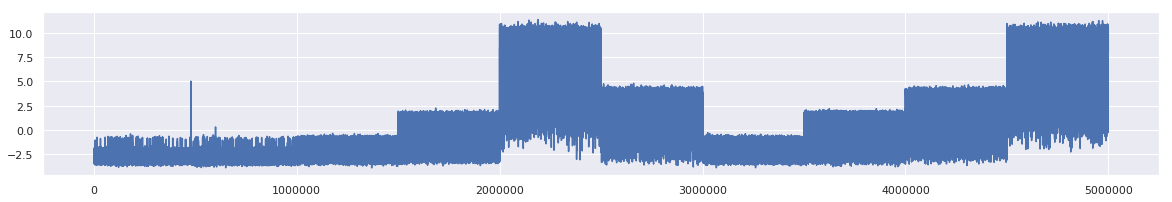

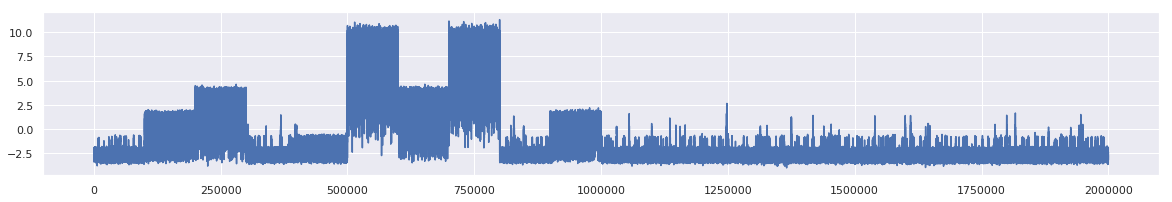

Reading and Normalizing Data Completed
Creating Features(Sun May 17 09:36:17 2020)
Feature Engineering Started...
Feature Engineering Completed...
Training Wavenet model with 5 folds of GroupKFold Started...(Sun May 17 09:36:37 2020)
Our training dataset shape is (1000, 4000, 23)
Our validation dataset shape is (250, 4000, 23)
Train on 1000 samples, validate on 250 samples
Epoch 1/180
F1 Macro Score: 0.81591
 - 21s - loss: 0.5439 - acc: 0.8483 - val_loss: 0.8629 - val_acc: 0.9013
Epoch 2/180
F1 Macro Score: 0.89838
 - 12s - loss: 0.1746 - acc: 0.9609 - val_loss: 0.4822 - val_acc: 0.9481
Epoch 3/180
F1 Macro Score: 0.92927
 - 12s - loss: 0.1340 - acc: 0.9674 - val_loss: 0.2117 - val_acc: 0.9654
Epoch 4/180
F1 Macro Score: 0.93513
 - 12s - loss: 0.1241 - acc: 0.9680 - val_loss: 0.1426 - val_acc: 0.9670
Epoch 5/180
F1 Macro Score: 0.93796
 - 12s - loss: 0.1179 - acc: 0.9684 - val_loss: 0.1173 - val_acc: 0.9682
Epoch 6/180
F1 Macro Score: 0.93728
 - 12s - loss: 0.1158 - acc: 0.9683 - val_l

In [11]:
%%time
# this function run our entire program
def run_everything():
    
    print(f'Reading Data Started...({time.ctime()})')
    train, test, sample_submission = read_data()
    train, test = normalize(train, test)
    print(f'Reading and Normalizing Data Completed')
        
    print(f'Creating Features({time.ctime()})')
    print(f'Feature Engineering Started...')
    train = run_feat_engineering(train, batch_size = GROUP_BATCH_SIZE)
    test = run_feat_engineering(test, batch_size = GROUP_BATCH_SIZE)
    train, test, features = feature_selection(train, test)
    print(f'Feature Engineering Completed...')
        
   
    print(f'Training Wavenet model with {SPLITS} folds of GroupKFold Started...({time.ctime()})')
    oof_ = run_cv_model_by_batch(train, test, SPLITS, 'group', features, sample_submission, EPOCHS, NNBATCHSIZE)
    print(f'Training completed...')
    
    return oof_
        
oof_ = run_everything()

# analysis

In [12]:
df_tr = pd.read_csv(PATH_TRAIN)

In [13]:
batch_list = []
for n in range(10):
    batchs = np.ones(500000)*n
    batch_list.append(batchs.astype(int))
batch_list = np.hstack(batch_list)
df_tr['batch'] = batch_list

In [14]:
# group 特徴量を作成
group = group_feat_train(df_tr)
df_tr = pd.concat([df_tr, group], axis=1)

In [15]:
y = df_tr['open_channels'].values

In [16]:
oof = np.argmax(oof_, axis=1).astype(int)

In [17]:
for group in sorted(df_tr['group'].unique()):
    idxs = df_tr['group'] == group
    oof_grp = oof[idxs].astype(int)
    y_grp = y[idxs]
    print(f'group_score({group}): {f1_score(y_grp, oof_grp, average="micro"):4f}')

group_score(0): 0.999616
group_score(1): 0.986599
group_score(2): 0.978761
group_score(3): 0.997806
group_score(4): 0.891790


In [18]:
max_ = df_tr.loc[df_tr['batch']==3]['signal'].max() 
min_ = df_tr.loc[df_tr['batch']==3]['signal'].min() 
idxs = (df_tr['batch']==7) & (df_tr['signal']>max_)
df_tr['signal'][idxs] = max_
idxs = (df_tr['batch']==7) & (df_tr['signal']<min_)
df_tr['signal'][idxs] = min_

<br>

可視化

In [19]:
x_idx = np.arange(len(df_tr))
idxs = y != oof

failed = np.zeros(len(df_tr))
failed[idxs] = 1

In [20]:
n = 200
b = np.ones(n)/n
failed_move = np.convolve(failed, b, mode='same')

(0, 5500000)

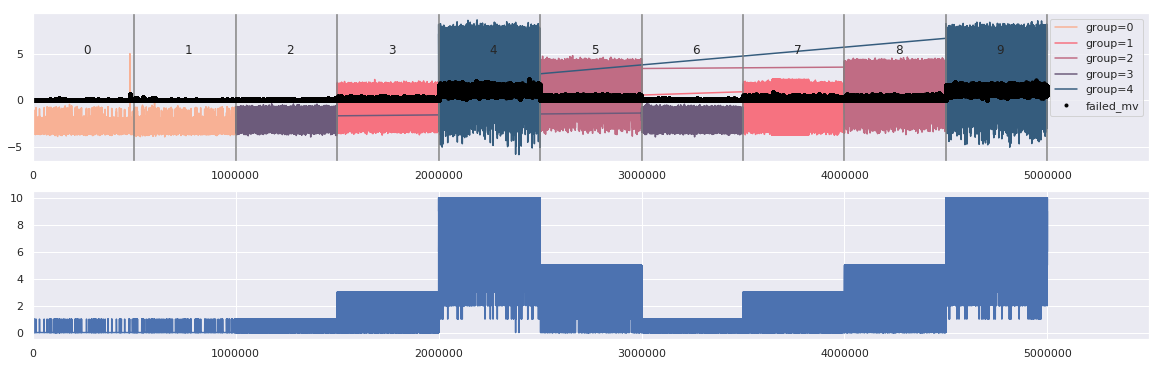

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(20, 6))
axs = axs.ravel()
# fig = plt.figure(figsize=(20, 3))

for i_gr, group in enumerate(sorted(df_tr['group'].unique())):
    idxs = df_tr['group'] == group
    axs[0].plot(np.arange(len(df_tr))[idxs], df_tr['signal'].values[idxs], color=cp[i_gr], label=f'group={group}')
for x in range(10): 
    axs[0].axvline(x*500000 + 500000, color='gray') 
    axs[0].text(x*500000 + 250000, 5, x)
axs[0].plot(x_idx, failed_move*10, '.', color='black', label='failed_mv')
axs[0].set_xlim(0, 5500000)
axs[0].legend()

axs[1].plot(x_idx, y)
axs[1].set_xlim(0, 5500000)

# fig.legend()